In [ ]:
using DifferentialEquations
using ParameterizedFunctions
using Plots
import RetinalChaos.Φ

In [ ]:
include("models.jl")

In [ ]:
using JSON2
function write_JSON(data, name_file)
    string_data = JSON2.write(data)
    open(name_file, "w") do f
        write(f, string_data)
    end
end
function read_JSON(name_file::String; is_type = NamedTuple{symbol, float64})
    nt = nothing
    open(name_file, "r") do f
        nt = JSON2.read(f, is_type)
    end
    nt 
end

# RetinalChaos.jl: An introduction
### In order to understand the code published here, these notebooks will act as simple tutorials on both how the model was designed. 

## Table of contents:

### _**[1] Introduction, Motivation, and Components**_
#### [1.1] Voltage and Potassium gating components of the model
#### **[1.2] Calcium and the Biochemical Reactions of the sAHP**
#### [1.3] Acetylcholine Diffusion and Dynamics
#### [1.4] Gaussian White noise and dynamics

### [2] Analyzing Data Output of the model
#### [2.1] Dynamical Analysis
#### [2.2] Fitting Experimental Data (Patch)
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers

# Just to recap the model in full is 
\begin{align}
   C_m\frac{dV}{dt} &= I_{leak} + I_{Ca} + I_K + I_{app} + I_{noise}\\
   \tau_N\frac{dN}{dt} &= \Lambda(V)(N_\infty(V) - N)\\
   \tau_C\frac{d[Ca^{2+}]}{dt} &= C_0 + \delta I_{Ca}(V) -\lambda  [Ca^{2+}]\\
   \tau_a\frac{da}{dt} &= \alpha * [Ca^{2+}]^4 * \left(1- a\right) - a\\
   \tau_b\frac{db}{dt} &= \beta * a^4 * (1 - b) - b\\
   \tau_{[ACh]}\frac{d[ACh]}{dt} &=  \nabla_{xx}^2 [ACh] + \rho \Phi(V) -[ACh]
\end{align}

#### Each individual Variable functions at a specific time scale. This is what gives different parts of the model their oscillatory behavior. The timescales are demonstrated below in this figure. 

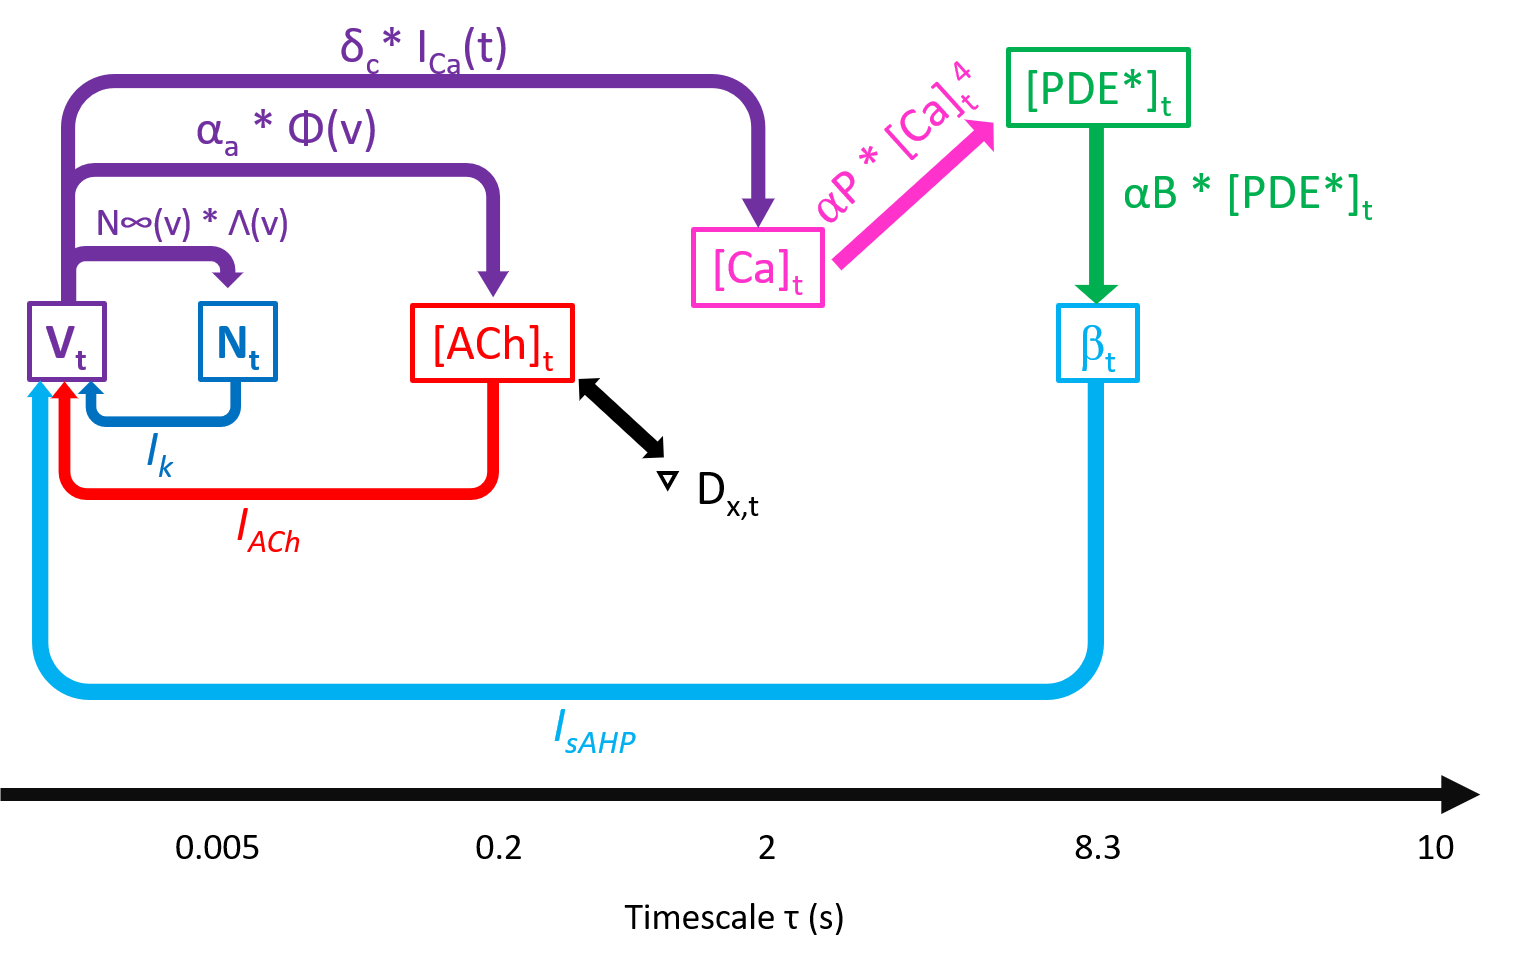

$$\require{mhchem}$$
### [1.2] Calcium and the Biochemical Reactions of the sAHP
The slow afterhyperpolarization is influenced by a two pore potassium channel called TREK1. Data from Ford & Fellar in 2013 showed the high gene expression of the transcripts necessary to produce TREK1 \cite{Ford2013}. Physiological data from this paper also showed that retinal waves were altered by the cAMP upregulator Forskolin. Retinal waves were unaltered by addition of apamin, an agonist of the small conductance calcium channel SK1. A paper published in 2006 by Dunn indicated that in the retinal ganglion cell layer, retinal waves had an effect on the cAMP and PKA concentrations.

The inhibition of TREK1 is driven by cAMP. cAMP decreases cause disinhibition of TREK1 channels. TREK1 is also demonstrated to have two sites for serine phosphorylation, Serine 300 and Serine 330. Other papers have found that calcium influxes can affect cAMP production. A computational model by Ohadi in 2019 relating calcium to cAMP production and hydrolysis in the dendritic spines of the hippocampus outlines this\cite{Ohadi2019}. This network can be simplified for the purpose of this model. 

The processes and equations here could have many physiological and biochemical motivations, however, they are all related to some cellular process. We can first start by outlining the processes by which intracellular Calcium becomes concentrated, and how this has an effect on the slow afterhyperpolarization of the cell. 

### Biochemical Pathway

#### [1.2.a] Generation of Calcium
This equation is used to describe the evolution of intracellular calcium. 
\begin{align*}
\tau_C\frac{d[Ca^{2+}]}{dt} &= C_0 + \delta I_{Ca}(V) - \lambda  [Ca^{2+}] 
\end{align*}

- $\tau_C$ is the rate of decay
- $C_0$ If this equation is not provided with a minimum amount of calcium, the concentration may dip to unnatural values. 
    - The minimum amount usually is set at $C_0 = 0.088\mu M$. 
- $\lambda$ represents a linear approximation of Calcium movement around in the cell and also the efflux of Calcium exchangers in the cell. Originally represented by the equation $\frac{\alpha_C}{H_c}$, this has been reduced to a single variable. 
- $\delta$ represents the magnitude of calcium influx given a $\frac{\mu M}{pA}$
- $I_{Ca}$ is the calcium current as described in the last notebook as:
\begin{align*}
I_{Ca}(Vt) &= -g_{Ca} * M_{\infty} * (V_t - E_{Ca})
\end{align*}

In [ ]:
#For these experiments we will conduct a mini "Voltage clamp ramp" at a range of -90.0mV to 10.0mV
v_range = collect(-90.0:0.5:10.0);

In [ ]:
# Taking the dynamics from the previous notebook:
V1 = -20.0
V2 = 20.0
M_INF(Vt) = (1 + tanh((Vt - V1)/V2))/2

g_Ca = 10.0
E_Ca = 40.0
I_Ca(Vt) = -g_Ca * M_INF(Vt) * (Vt - E_Ca) 

C_0 = 88.0/1000
C_i = 0.0
λ = 2.702
δ = 10.503/1000
τc = 2000.0
#Adding in the new variables
Inst_Ca(C_0, C_i, Vt, λ, δ, τc) = (C_0 - λ*C_i + δ*I_Ca(Vt))/τc 

In [ ]:
# Here are some other parameters needed for the model but not used in this section
g_leak = 2.0
E_leak = -70.0
V3 = -25.0
V4 = 7.0
#For evolution of the Potassium Activation
τn = 5.0 #time constant of K relaxation
n0 = 0.0 #Choose an initial point for the activation %
#And for the Calcium currents we have this equation
g_K = 7.0
E_K = -90.0

In [ ]:
#Different Parameters and their effect on the Calcium influx
p = plot()
for delta = 0.005:0.001:0.025
    CINST = map(v -> Inst_Ca(C_0, C_i, v, λ, delta, τc), v_range)
    plot!(p, v_range, CINST, legend = :none, linewidth = 2.0, lc = :algae, line_z = delta, clim = (0.005, 0.025))
end
title!(p, "Instantaneous Calcium Influx while varying delta_C")
ylabel!(p, "Calcium Influx (nM/s)")
xlabel!(p, "Voltage (mV)")
p

#### However in order to fully understand the dynamics of calcium, we can drop into the ODE interface which we had utilized in the previous notebook. This time adding a 3rd expression for calcium (described above) 

In [ ]:
#We outline the Auxillary equations
M_INF(V, V1, V2) = (1 + tanh((V - V1)/V2))/2;
N_INF(V, V3, V4) = (1 + tanh((V - V3)/V4))/2;
LAM(V, V3, V4) = cosh((V-V3)/(2*V4));
Φ(v, κ, V_0)     = 1/(1 + exp(-κ * (v - V_0)))
#In this example we will simulate a voltage step then let the cell return to baseline
t_act = 70.0;
t_dur = t_act + 100.0;
cb1 = ContinuousCallback((u, t, integrator) -> (t < t_act), integrator -> integrator.u[1] = integrator.p[9]);
cb2 = ContinuousCallback((u, t, integrator) -> (t < t_dur),  integrator -> integrator.u[1] = -60.0);
cb = CallbackSet(cb1, cb2);

In [ ]:
Calcium_Model = @ode_def begin
    dIAPP = 0.0
    dv = ((-g_leak * (v - E_leak)) + (-g_Ca * M_INF(v, V1, V2) * (v - E_Ca)) + (-g_K * n * (v - E_K)) + IAPP)/C_m
    dn = (LAM(v, V3, V4) * ((N_INF(v, V3, V4) - n)))/τn
    dc = (C_0 - λ*c + δ*(-g_Ca * M_INF(v, V1, V2)* (v - E_Ca)))/τc
    end g_leak E_leak g_Ca V1 V2 E_Ca g_K E_K I_app C_m V3 V4 τn C_0 λ δ τc;

In [ ]:
I_app = 10.0;
C_m = 22.0;
u0 = [0.0, -70.0, 0.0, 0.088];
pars = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, I_app, C_m, V3, V4, τn, C_0, λ, δ, τc];
tspan = (0.0, 4000.0);
prob = ODEProblem(Calcium_Model, u0, tspan, pars);
println("Time it took to simulate 200ms:")
@time sol = solve(prob, saveat = 1.0, callback = cb);
#We can extract voltage and N traces from the model
time = sol.t
dt = time[2] #The change in time can easily be determined by taking the second point, however we set it to 0.01
println("dt = $dt") #This we can check to ensure 
iapp = map(x -> x[1], sol.u);
v_trace = map(x -> x[2], sol.u);
n_trace = map(x -> x[3], sol.u);
c_trace = map(x -> x[4], sol.u);

In [ ]:
p = plot(layout = grid(3,1))
title!(p[1], "Representative traces with 50pA of current injection")

plot!(p[1], time, iapp, linewidth = 2.0, c = :red, legend = :none)
ylabel!(p[1], "Injected Current (pA)")

plot!(p[2], time, v_trace, linewidth = 2.0, c = :magenta, legend = :none)
ylabel!(p[2], "Voltage (mV)")

plot!(p[3], time, c_trace, linewidth = 2.0, c = :blue, legend = :none)
ylabel!(p[3], "[Ca2+] (nM)")
xlabel!(p[3], "Time (ms)")

##### By varying the variables $\alpha_C$, $\delta_C$ and $\tau_C$ we can

In [ ]:
#What is the effect of modifying alpha C?
tspan = (0.0, 2000.0);
u0 = [0.0, -70.0, 0.0, 0.0880];
p = plot(layout = grid(2,1))

title!(p[1], "Effect of Ca Conc while varying alpha_C")
plot!(p[1], time, iapp, linewidth = 2.0, c = :red, legend = :none)
for lambda = 1.0:5.4
    pars = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, I_app, C_m, V3, V4, τn, C_0, lambda, δ, τc];
    prob = ODEProblem(Calcium_Model, u0, tspan, pars);
    sol = solve(prob, saveat = 1.0, callback = cb);
    time = sol.t
    c_trace = map(x -> x[4], sol.u);
    iapp = map(x -> x[1], sol.u);
    plot!(p[2], time, c_trace, linewidth = 2.0, c = :blues, legend = :none, line_z = lambda, clims = (1.0, 6.0))
end
println("aC Checkpoint")
ylabel!(p[1], "Injected Current (pA)")
ylabel!(p[2], "[Ca2+] (nM)")
xlabel!(p[2], "Time (ms)")

In [ ]:
p = plot(layout = grid(2,1))
title!(p[1], "Effect of Ca Conc while varying delta_C")
plot!(p[1], time, iapp, linewidth = 2.0, c = :red, legend = :none)
for delta = 5.0:2.5:15.0
    pars = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, I_app, C_m, V3, V4, τn, C_0, λ, delta, τc];
    prob = ODEProblem(Calcium_Model, u0, tspan, pars);
    sol = solve(prob, saveat = 1.0, callback = cb);
    time = sol.t
    c_trace = map(x -> x[4], sol.u);
    iapp = map(x -> x[1], sol.u);
    plot!(p[2], time, c_trace, linewidth = 2.0, c = :blues, legend = :none, line_z = delta, clims = (5.0, 15.0))
end
ylabel!(p[1], "Injected Current (pA)")
ylabel!(p[2], "[Ca2+] (nM)")
xlabel!(p[2], "Time (ms)")

In [ ]:
p = plot(layout = grid(2,1))
title!(p[1], "Effect of Ca Conc while varying tau_C")
plot!(p[1], time, iapp, linewidth = 2.0, c = :red, legend = :none)
for tc = 200:200:2000
    pars = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, I_app, C_m, V3, V4, τn, C_0, λ, δ, tc];
    prob = ODEProblem(Calcium_Model, u0, tspan, pars);
    sol = solve(prob, saveat = 1.0, callback = cb);
    time = sol.t
    c_trace = map(x -> x[4], sol.u);
    iapp = map(x -> x[1], sol.u);
    plot!(p[2], time, c_trace, linewidth = 2.0, c = :blues, legend = :none, line_z = tc, clims = (200.0, 2000.0))
end
println("tC Checkpoint")
ylabel!(p[1], "Injected Current (pA)")
ylabel!(p[2], "[Ca2+] (nM)")
xlabel!(p[2], "Time (ms)")

##### Calcium concentration influences the formation rate of cAMP. We can describe this process as a single reaction which we will represnt by $A_t$. 

\begin{align}
\tau_{A}\frac{dA}{dt} &= \alpha * [Ca^{2+}]^4 * \left(1 - A\right) - A
\end{align}

- $\alpha$ represents the forward rate of Phosphodiesterase (PDE) , adenyl cyclse (AC1). These will be explained more in a later notebook. 
- In this process, 4 calciums are used, so in this equation, calcium is taken to the 4th power. 
- The equation grows exponentially and then hits a saturation point at 1. The generalized form for this equation is the logistic growth equation. $\alpha * [Substrate] * (1 - [Product])$
- The numerical equation also includes a exponential decay which is represented by $-[Product]$
- - We can take into account that this reaction is occurring over a very slow period (~8-15 seconds). We can account for this by dividing the entire equation by the decay rate ($\tau_A$) will be much slower (in the case of our reactions, it will be much higher.)
- $A_t$ however is equal to the breakdown of cAMP, so the concentration of cAMP = (1-A)

##### The presence of 4 cAMPs causes Activation of 2 PKA. TREK has 2 serines, that when phosphorylyzed to the inactive form pTREK. The phosphorylyzed serines act to block the potassium channel, which decreases/inactivates $I_{sAHP}$. When cAMP breakdown is occurring, PKA begins to decrease, and pTREK dephosphorylyzes into TREK. This activates the $I_{sAHP}$ and the afterhyperpolarization occurs. 

- These reactions are represented by $B_t$ and indicate the return of pTREK to TREK. 

\begin{align}
\tau_{B}\frac{dB}{dt} &= \beta * A^4 * \left(1 - B\right) - B
\end{align}

# Later these equations and the chemical reactions behind them will be explored. 

In [ ]:
α  = 62.5#e-10*1000
β = 4.25
τa = 8300.0;
τb = 8300.0;
g_sAHP = 2.0

In [ ]:
secondary_model = @ode_def begin
    dv = ((-g_leak * (v - E_leak)) + (-g_Ca * M_INF(v, V1, V2) * (v - E_Ca)) + (-g_K * n * (v - E_K)) + (-g_sAHP * b * (v - E_K)) + I_app)/C_m
    dn = (LAM(v, V3, V4) * ((N_INF(v, V3, V4) - n)))/tau_N
    dc = (C_0 + δ*(-g_Ca * M_INF(v, V1, V2)* (v - E_Ca)) - λ*c)/τc
    da =  (α*c^4*(1-a) - a)/τa
    db =  (β*a^4*(1-b) - b)/τb
    #dACh = (ρ*Φ(v, 0.2, -40.0) - ACh)/τACh
    end g_leak E_leak g_Ca V1 V2 E_Ca g_K E_K g_sAHP I_app C_m V3 V4 tau_N C_0 λ δ τc α τa β τb ρ τACh σ;

In [ ]:
u0 = [-70.0, 0.0, 0.0, 0.0, 0.0];
p0 = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, g_sAHP, 10.0, C_m, V3, V4, τn, C_0, λ, δ, τc, α, τa, β, τb, 1.0, 200.0, 0.0];
tspan = (0.0, 4000.0);
prob = ODEProblem(secondary_model, u0, tspan, p0);
println("Time it took to simulate 200ms:")
@time sol = solve(prob, saveat = 1.0);
#We can extract voltage and N traces from the model

In [ ]:
plot(sol, vars = [:v, :n, :c, :a, :b], ylabel = ["V (mV)" "N" "[Ca] uM" "[A] uM" "[B] uM"], legend = :none, layout = grid(5, 1), size = (1000, 750))

In [ ]:
α  = 62.5#e-10*1000
β = 4.25
τa = 8300.0;
τb = 8300.0;
g_sAHP = 2.0

In [ ]:
c_keys = tuple(secondary_model.params...)
c_nt = NamedTuple{c_keys}(p0)
write_JSON(c_nt, "params.json")

#### Adjusting the parameters $\alpha$ and $\tau_a$.

- The parameter $\alpha$ determines how quickly cAMP will be broken down. Adjusting this will have effects on the rise of the value $A_t$
- The parameter $\tau_a$ determines how quickly cAMP regeneration occurs (or how quickly $A_t$ decays. 

In [ ]:
alp_rng = LinRange(20.0, 100.0, 10)
p = plot(layout = grid(5, 1), size = (1000, 750))
title!(p[1], "Adjusting the value for alpha")
for alpha in alp_rng
    u_new = [-70.0, 0.0, 0.0, 0.0, 0.0];
    p_new = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, g_sAHP, 10.0, C_m, V3, V4, τn, C_0, λ, δ, τc, alpha, τa, β, τb, 1.0, 200.0];
    prob = ODEProblem(secondary_model, u_new, tspan, p_new);
    sol = solve(prob, saveat = 10.0);
    plot!(p, sol, vars = [:v, :n, :c, :a, :b],  ylabel = ["V (mV)" "N" "[Ca] uM" "[A] uM" "[B] uM"], xlabel = "Time (ms)", line_z = alpha, clims = (alp_rng[1], alp_rng[end]), legend = :none)
end
p

In [ ]:
ta_rng = LinRange(2e3, 10e3, 5)
p = plot(layout = grid(5, 1), size = (1000, 750))
title!(p[1], "Adjusting the value for tau_a")
for ta in ta_rng
    u_new = [-70.0, 0.0, 0.0, 0.0, 0.0];
    p_new = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, g_sAHP, 10.0, C_m, V3, V4, τn, C_0, λ, δ, τc, α, ta, β, τb, 1.0, 200.0];
    prob = ODEProblem(secondary_model, u_new, tspan, p_new);
    sol = solve(prob, saveat = 10.0);
    plot!(p, sol, vars = [:v, :n, :c, :a, :b],  ylabel = ["V (mV)" "N" "[Ca] uM" "[A] uM" "[B] uM"], xlabel = "Time (ms)", line_z = ta, clims = (ta_rng[1], ta_rng[end]), legend = :none)
end
p

#### Adjusting the parameters $\beta$ and $\tau_b$.

- The parameter $\beta$ determines how quickly TREK will be dephosphorylyzed. Adjusting this will have effects on the rise of the value $A_t$
- The parameter $\tau_b$ determines how quickly pTREK phosphorylation occurs. 

In [ ]:
bet_rng = LinRange(1.0, 10.0, 10)
p = plot(layout = grid(5, 1), size = (1000, 750))
title!(p[1], "Adjusting the value for Beta")
for beta in bet_rng
    u_new = [-70.0, 0.0, 0.0, 0.0, 0.0];
    p_new = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, g_sAHP, 10.0, C_m, V3, V4, τn, C_0, λ, δ, τc, α, τa, beta, τb, 1.0, 200.0];
    prob = ODEProblem(secondary_model, u_new, tspan, p_new);
    sol = solve(prob, saveat = 10.0);
    plot!(p, sol, vars = [:v, :n, :c, :a, :b],  ylabel = ["V (mV)" "N" "[Ca] uM" "[A] uM" "[B] uM"], xlabel = "Time (ms)", line_z = beta, clims = (bet_rng[1], bet_rng[end]), legend = :none)
end
p

In [ ]:
tb_rng = LinRange(2e3, 10e3, 5)
p = plot(layout = grid(5, 1), size = (1000, 750))
title!(p[1], "Adjusting the value for tau_a")
for tb in tb_rng
    u_new = [-70.0, 0.0, 0.0, 0.0, 0.0];
    p_new = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, g_sAHP, 10.0, C_m, V3, V4, τn, C_0, λ, δ, τc, α, τa, β, tb, 1.0, 200.0];
    prob = ODEProblem(secondary_model, u_new, tspan, p_new);
    sol = solve(prob, saveat = 10.0);
    plot!(p, sol, vars = [:v, :n, :c, :a, :b],  ylabel = ["V (mV)" "N" "[Ca] uM" "[A] uM" "[B] uM"], xlabel = "Time (ms)", line_z = tb, clims = (tb_rng[1], tb_rng[end]), legend = :none)
end
p

### Discussion

- Previous studies have found the the length of the hyperpolarization is proportional to the length of the spike. Eliminating calcium currents by using blockers also eliminates the AHP. For this reason, it is believed that the afterhyperpolarization current ($I_{sAHP}$) is based on some calcium dependent mechanism. The main contributor to the $I_{sAHP}$ is thought to be the Two-pore potassium channel TREK. Genomic studies have found that TREK is the most highly expressed potassium channel in the SACs. Studies on TREK (use TREK paper) have found that it is inactivated by sequential phosphorylation of two Serine groups in the intracellular section of the protein. Other studies have found that adenyl cyclase activators (such as Forskolin) have been demonstrated to increase intracellular concentration of cAMP. This decreases the $I_{sAHP}$ which increases the frequency at which waves occur.  

- The specific mechanism by which this occurs in the starburst amacrine cell is still not fully worked out. However, in hippocampal neurons, Calcium and cAMP interaction occurs through Adenyl Cyclase, Phosphodiesterase, and Adenosine. Considering how these reactions are known to occur in the SACs (CITE THIS), a pathway connecting calcium influx and TREK disinhibition is hypothetically possible. In future models, the specific reactions will be worked out and modelled. For now these reactions were grouped into a two logisitic growth equations $A_t$ and $B_t$.

### In the next notebook

- We will discuss how acetylcholine release occurs. 
- We will introduce partial differential equations necessary to describe diffusion of Acetylcholine into the intracellular space. 